In [1]:
try:
    spark.stop()
except:
    pass

import findspark
findspark.init()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
import seaborn as sns
from tqdm import tqdm
import time

sns.set(color_codes=True)

In [2]:
def centroids_init(centroids_num):
    # initialize k centroids randomly
    return -0.5 + np.random.rand(centroids_num, 2)

In [3]:
centroids = centroids_init(3)

In [4]:
def dist_calc(point1, point2):
    return np.sum(np.square(np.abs(point1 - point2)))

In [5]:
class spark:
    def __init__(self):
        self.spark = SparkSession\
                .builder\
                .master("local")\
                .appName("k-means")\
                .getOrCreate()
        self.sc = self.spark.sparkContext
    
    def end(self):
        self.spark.stop()
    
    @staticmethod
    def label(point):
        global centroids
        # label each point to its closest centroid
        dist_min = float('inf')
        idx = 0
        for i in range(centroids.shape[0]):
            dist = dist_calc(point, centroids[i])
            if dist < dist_min:
                dist_min = dist
                idx = i
        return (idx, (1, point))
    
    def k_means(self, points, threshold):
        global centroids
        data = self.sc.parallelize(points)
        while True:
            labeled = data.map(self.label)
            # compute the new centroid of each cluster
            reduced = labeled.reduceByKey(lambda a, b: tuple(map(sum, zip(a, b))))
            points_sum = reduced.collect()
            
            converge = True
            for i in points_sum:
                if i[1][0] == 0: # no point was assigned, initialize centroids again
                    centroids = centroids_init(centroids.shape[0])
                    continue
                else:
                    idx = i[0]
                    
                    centroid = i[1][1] / i[1][0]
                    if converge and dist_calc(centroids[idx], centroid) > threshold:
                        converge = False
                    centroids[idx] = centroid
            
            if converge == True:
                return

In [7]:
spark_obj = spark()

-0.0007373


In [7]:
def k_means(points, threshold):
    global centroids
    # initialize k centroids randomly
    centroids = centroids_init(centroids.shape[0])
    while True:
        # label each point to its closest centroid
        labeled = [np.empty((0, 2)) for i in range(centroids.shape[0])]
        for i in range(points.shape[0]):
            dist_min = float('inf')
            idx = 0
            for j in range(centroids.shape[0]):
                dist = dist_calc(points[i], centroids[j])
                if dist < dist_min:
                    dist_min = dist
                    idx = j
            labeled[idx] = np.vstack((labeled[idx], points[i]))
        
        converge = True
        # compute the new centroid of each cluster
        for i in range(centroids.shape[0]):
            # no point was assigned
            if labeled[i].shape[0] == 0:
                centroids = centroids_init(centroids.shape[0])
                continue
            
            centroid = np.sum(labeled[i], axis=0) / labeled[i].shape[0]
            if converge and dist_calc(centroid, centroids[i]) > threshold:
                converge = False
            centroids[i] = centroid
        # until centroids converge
        if converge == True:
            return

In [8]:
def points_gen(centroids_num, size, scale):
    real_centroids = centroids_init(centroids_num)
    points = np.empty((0, 2))
    for i in range(centroids_num):
        for j in range(size):
            x = np.random.normal(real_centroids[i, 0], scale=scale)
            y = np.random.normal(real_centroids[i, 1], scale=scale)
            points = np.vstack((points, [x, y]))
    return real_centroids, points

In [9]:
def SSE_plot(iter_num, points_num, opt):
    global centroids, spark_obj
    # the sum of the squared error between derived centroids and real centroids
    SSE_log = np.empty(iter_num)
    for i in tqdm(range(iter_num)):
        # sample points were generated according to the normal distribution of real centroids
        # with standard deviation of 0.06
        real_centroids, points = points_gen(centroids.shape[0], points_num, 0.06)
        centroids = centroids_init(centroids.shape[0])
        if opt == "spark":
            spark_obj.k_means(points, 1E-16)
        elif opt == "matrix":
            k_means(points, 1E-16)
        
        SSE = 0
        for j in range(points.shape[0]):
            dist_min = float('inf')
            for k in range(centroids.shape[0]):
                dist = dist_calc(points[j], centroids[k])
                if dist < dist_min:
                    dist_min = dist
            SSE += dist_min
        SSE_log[i] = SSE
    mean = np.mean(SSE_log)
    stDev = np.std(SSE_log)
    X_label = "SSE, mean=%.6f, stDev=%.6f" % (mean, stDev)
    X = pd.Series(SSE_log, name=X_label)
    sns.distplot(X);

In [10]:
def scatter_plot(points_num, opt):
    global centroids
    real_centroids, points = points_gen(centroids.shape[0], points_num, 0.06)
    centroids = centroids_init(centroids.shape[0])
    if opt == "spark":
        spark_obj.k_means(points, 1E-16)
    elif opt == "matrix":
        k_means(points, 1E-16)
    points_plt = plt.scatter(points[:, 0], points[:, 1], c='#1f77b4')
    real_centroids_plt = plt.scatter(real_centroids[:, 0], real_centroids[:, 1], c='#9467bd')
    centroids_plt = plt.scatter(centroids[: , 0], centroids[:, 1], c='#ff7f0e')
    plt.legend((points_plt, real_centroids_plt, centroids_plt), ("sample points", "real centroids", "derived centroids"))
    plt.show()

100%|██████████| 1024/1024 [01:39<00:00, 10.25it/s]


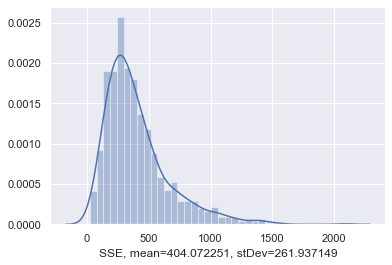

In [11]:
SSE_plot(1024, 1024, opt="none")

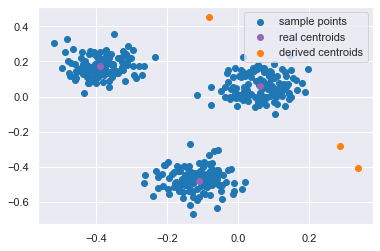

In [12]:
scatter_plot(128, opt="none")

100%|██████████| 1024/1024 [17:40<00:00,  1.04s/it]


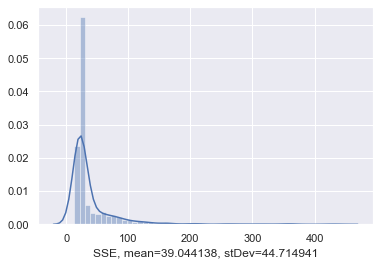

In [13]:
SSE_plot(1024, 1024, opt="spark")

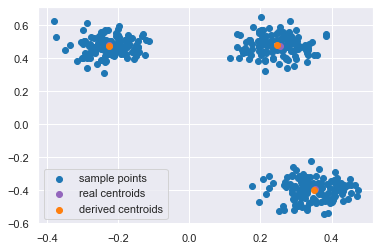

In [14]:
scatter_plot(128, opt="spark")

100%|██████████| 1024/1024 [15:09<00:00,  1.13it/s]


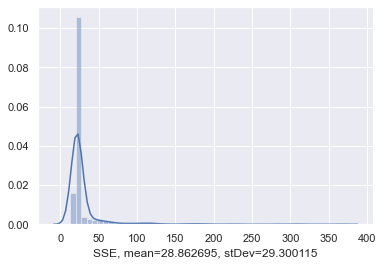

In [15]:
SSE_plot(1024, 1024, opt="matrix")

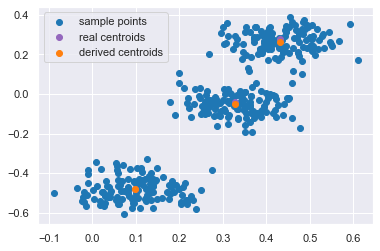

In [17]:
scatter_plot(128, opt="matrix")

In [11]:
centroids = centroids_init(2)

In [12]:
def benchmark(X_min, interval, iter_num, opt):
    global centroids, spark_obj
    exe_time = np.empty((interval, iter_num))
    exe_log = np.empty((2, interval)) # [[mean], [stDev]]
    for i in tqdm(range(interval)):
        points_num = np.power(2, X_min + i)
        for j in range(iter_num):
            real_centroids, points = points_gen(centroids.shape[0], points_num, 0.06)
            centroids = centroids_init(centroids.shape[0])
            
            start = time.process_time_ns()
            if opt == "spark":
                spark_obj.k_means(points, 1E-16)
            elif opt == "matrix":
                k_means(points, 1E-16)
            end = time.process_time_ns()
            
            # execution time per points
            exe_time[i][j] = (end - start) / points_num
    df = pd.DataFrame(exe_time, index=range(interval))
    ax = sns.pointplot(data=df.T.values)
    # Add std deviation bars to the previous plot
    mean = df.mean(axis=1)
    std  = df.std(axis=1)
    exe_log[0, :] = mean
    exe_log[1, :] = std
    print(exe_log)
    ax.errorbar(df.index, mean, yerr=std, fmt='-o')
    X_label = "pow(2, n + %d) points" % (X_min)
    ax.set(xlabel=X_label, ylabel="average exe time per point, ns")
    plt.show()

100%|██████████| 6/6 [2:03:56<00:00, 1239.38s/it]


[[18026.35574341 13351.17530823 10477.37979889  9319.86856461
   8017.61722565  7546.21446133]
 [ 6920.17774088  4260.92343479  2831.85079597  3580.18397881
    821.67989734   424.55475638]]


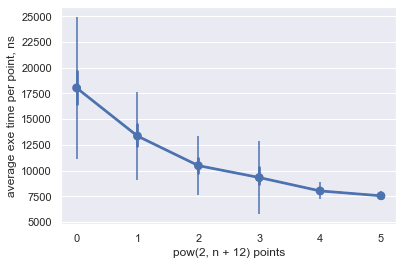

In [13]:
benchmark(12, 6, 64, opt="spark")

100%|██████████| 6/6 [7:53:59<00:00, 4739.96s/it]

[[ 263097.80502319  350305.06706238  250908.45108032  631649.52945709
   552729.16674614 1192331.0713768 ]
 [ 247819.35373727  785790.80995949  205623.88978133 1716845.37816406
   575718.61295234 1043455.12060724]]


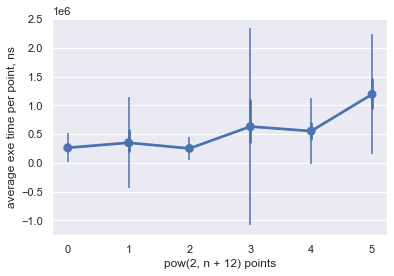

In [15]:
benchmark(12, 6, 64, opt="matrix")

In [16]:
 spark_obj.end()